# A Backdoor Detector for BadNets Trained on the YouTube Face Dataset using the Fine-Pruning Defense

Members: Zihan Cheng(zc2237), Zeqi Kang(zk2038), Zhiying Cui(zc2191)

Github link: https://github.com/ray0nv3rt/ML_Security_Project


## 1. Prepare the BadNet model and dataset

Mount the google drive. The working directory in our Google Drive is located at `/content/drive/MyDrive/EL-GY-9163/project`.

In [25]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
# change to the working dirctory
%cd /content/drive/MyDrive/EL-GY-9163/project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EL-GY-9163/project


If you execute the notebook in your local environment, skip the above code block. Follow the instruction in the `README.md` which tells how to download the dataset to the folder `data` and continue the following sections.

In [26]:
import tensorflow as tf
import keras
import keras.backend as K
from keras import initializers
from keras import Model

import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 BadNet models

There are four BadNets in the folder `models` waiting to be repaired:
- `sunglasses_bd_net`
- `anonymous_1_bd_net`
- `anonymous_2_bd_net`
- `multi_trigger_multi_target_bd_net`

Noted that we do not have the backdoored dataset that trained `anonymous_2_bd_net`. However, we are still going to construct GoodNet for `anonymous_2_bd_net` but without evaluating its performance.


In [27]:
bd_model_path = ['./models/sunglasses_bd_net.h5',
                 './models/anonymous_1_bd_net.h5',
                 './models/anonymous_2_bd_net.h5',
                 './models/multi_trigger_multi_target_bd_net.h5']

A script `eval.py` is given to see the accuracy(ACC) and the attack success rate(ASR) of each BadNet on the clean test dataset and the backdoored dataset. Let's see how the ACC and ASR of each BadNet are before repairing.

In [ ]:
# anonymous_1_bd_net
!python eval.py data/clean_test_data.h5 data/anonymous_1_poisoned_data.h5 models/anonymous_1_bd_net.h5

2021-12-20 02:48:30.992815: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-20 02:48:40.018649: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification accuracy: 56.22759158222915
2021-12-20 02:48:48.705366: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52674848 exceeds 10% of free system memory.
Attack Success Rate: 91.48480124707716


In [ ]:
# sunglasses_bd_net
!python eval.py data/clean_test_data.h5 data/sunglasses_poisoned_data.h5 models/sunglasses_bd_net.h5

2021-12-20 02:52:27.494660: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-20 02:52:37.649533: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification accuracy: 42.361652377240844
2021-12-20 02:52:49.186996: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Attack Success Rate: 99.94544037412315


In [ ]:
# multi_trigger_multi_target_bd_net (eyebrows)
!python eval.py data/clean_test_data.h5 data/Multi-trigger\ Multi-target/eyebrows_poisoned_data.h5 models/multi_trigger_multi_target_bd_net.h5

2021-12-20 02:54:27.948426: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-20 02:54:38.673573: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification accuracy: 43.19563522992985
2021-12-20 02:54:46.156559: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52674848 exceeds 10% of free system memory.
Attack Success Rate: 88.18199532346064


In [ ]:
# multi_trigger_multi_target_bd_net (lipstick)
!python eval.py data/clean_test_data.h5 data/Multi-trigger\ Multi-target/lipstick_poisoned_data.h5 models/multi_trigger_multi_target_bd_net.h5

2021-12-20 02:55:45.293655: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-20 02:55:55.890299: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification accuracy: 43.19563522992985
2021-12-20 02:56:03.456672: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52674848 exceeds 10% of free system memory.
Attack Success Rate: 91.99142634450507


In [ ]:
# multi_trigger_multi_target_bd_net (sunglasses)
!python eval.py data/clean_test_data.h5 data/Multi-trigger\ Multi-target/sunglasses_poisoned_data.h5 models/multi_trigger_multi_target_bd_net.h5

2021-12-20 02:56:23.383427: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-20 02:56:32.659270: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification accuracy: 43.19563522992985
2021-12-20 02:56:41.209775: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52674848 exceeds 10% of free system memory.
Attack Success Rate: 100.0


From the ouputs, we can see that the overall ACCs are not good and ASRs are pretty high.

### 1.2 Import dataset

All provided dataset is saved in the folder `data`.

In [28]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

def get_accuracy_cl(bd_model, cl_x, cl_y):
    cl_label_p = np.argmax(bd_model.predict(cl_x), axis=1)
    cl_acc = np.mean(np.equal(cl_label_p, cl_y))*100
    print('Clean Classification Accuracy:', cl_acc)
    return cl_acc

def get_attack_rate_bd(bd_model, bd_x, bd_y):
    bd_label_p = np.argmax(bd_model.predict(bd_x), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y))*100
    print('Attack Success Rate:', asr)
    return asr

In [29]:
# load clean dataset
cl_x_test, cl_y_test = data_loader('./data/clean_test_data.h5')
cl_x_valid, cl_y_valid = data_loader('./data/clean_validation_data.h5')

bd_dataset_path = ['./data/sunglasses_poisoned_data.h5',
                   './data/anonymous_1_poisoned_data.h5',
                   './data/Multi-trigger Multi-target/eyebrows_poisoned_data.h5',
                   './data/Multi-trigger Multi-target/lipstick_poisoned_data.h5',
                   './data/Multi-trigger Multi-target/sunglasses_poisoned_data.h5']

N = len(set(cl_y_test))

In [ ]:
print('cl_x_test.shape:', cl_x_test.shape)
print('cl_x_valid.shape:', cl_x_valid.shape)
print('Number of clean labels:', N)

cl_x_test.shape: (12830, 55, 47, 3)
cl_x_valid.shape: (11547, 55, 47, 3)
Number of clean labels: 1283


We are only provided with the BadNet and the clean validation dataset to repair the model. 
There are 11547 images in the clean validation dataset `cl_x_valid`. Each of the images is 55 pixels in length and 57 pixels in width with RGB 3 channels.

There are 5 backdoored datasets given in the folder. We can plot some images to have some primitive sense of how those images look like.

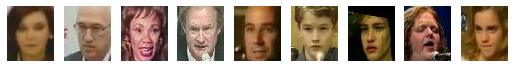

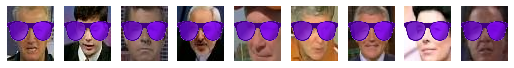

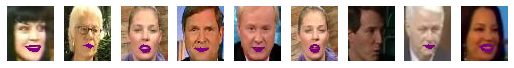

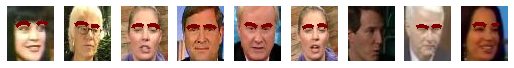

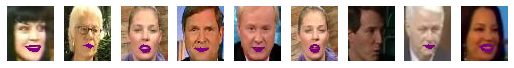

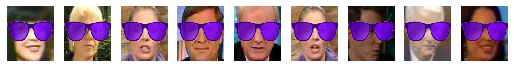

In [ ]:
def plot_images(row, col, images):
    plt.figure(figsize=(col, row))
    for i in range(1, row*col):
        plt.subplot(row, col, i)
        plt.axis('off')
        plt.imshow(images[i] / 255)

plot_images(1, 10, cl_x_valid)
for data_path in bd_dataset_path:
    x, y = data_loader(data_path)
    plot_images(1, 10, x)

## 2. Repair the BadNets

Given a backdoored neural network classifier `model_B` and a validation dataset of clean data `cl_x_valid`, we are going to use the fine-pruning defense againt the attack. Our strategy to repair the BadNet is as follows:

- Training a Baseline model: A Baseline model `model_base` is trained on the clean validation dataset. Although the accuracy of `model_base` is not good enough because of the limited numbers of the training dataset, it is a perfect reference to help us in finding pruning channel.

- Pruning: For each layer intended to be pruned, we compute the absolute difference `abs_diff` between normalized average activation values of baseline model `model_base` and normalized average activation values of new model `model_B_prime` over the entire validation dataset. The decreasing order of `abs_diff` determines the sequence of our pruning process.

- Retraining: After pruning, we will obtain a new network `model_B_prime`. Use the clean validation dataset to retrain `model_B_prime` with few number of epochs and a small learning rate.

### 2.1 Train a Baseline model

Before getting started, we first need to train a Baseline model using the clean validation dataset. The reason we train a baseline model is that we need a reference to roughly know which neurons would probably be unactivated in the original model that is not poisoned by the backdoored dataset.

In [ ]:
def Net():
    # define input
	x = keras.Input(shape=(55, 47, 3), name='input')
	# feature extraction
	conv_1 = keras.layers.Conv2D(20, (4, 4), activation='relu', name='conv_1')(x)
	pool_1 = keras.layers.MaxPooling2D((2, 2), name='pool_1')(conv_1)
	conv_2 = keras.layers.Conv2D(40, (3, 3), activation='relu', name='conv_2')(pool_1)
	pool_2 = keras.layers.MaxPooling2D((2, 2), name='pool_2')(conv_2)
	conv_3 = keras.layers.Conv2D(60, (3, 3), activation='relu', name='conv_3')(pool_2)
	pool_3 = keras.layers.MaxPooling2D((2, 2), name='pool_3')(conv_3)
	# first interpretation model
	flat_1 = keras.layers.Flatten()(pool_3)	
	fc_1 = keras.layers.Dense(160, name='fc_1')(flat_1)
	# second interpretation model
	conv_4 = keras.layers.Conv2D(80, (2, 2), activation='relu', name='conv_4')(pool_3)
	flat_2 = keras.layers.Flatten()(conv_4)
	fc_2 = keras.layers.Dense(160, name='fc_2')(flat_2)
	# merge interpretation
	merge = keras.layers.Add()([fc_1, fc_2])
	add_1 = keras.layers.Activation('relu')(merge)
	drop = keras.layers.Dropout(0.5)
	# output
	y_hat = keras.layers.Dense(1283, activation='softmax', name='output')(add_1)
	model = keras.Model(inputs=x, outputs=y_hat)
	# summarize layers
	#print(model.summary())
	# plot graph
	#plot_model(model, to_file='model_architecture.png')

	return model

K.clear_session()
model_base = Net()

# loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_base.compile(optimizer='adam',
                   loss=loss_fn,
                   metrics=['accuracy'])

In [ ]:
# training on clean validation dataset
model_base.fit(cl_x_valid, cl_y_valid, epochs=15)
model_base.save('./models/baseline_net.h5')

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


361/361 [==============================] - 37s 97ms/step - loss: 6.9486 - accuracy: 0.0095
Epoch 2/15
361/361 [==============================] - 35s 96ms/step - loss: 4.2681 - accuracy: 0.2705
Epoch 3/15
361/361 [==============================] - 35s 98ms/step - loss: 2.0686 - accuracy: 0.6046
Epoch 4/15
361/361 [==============================] - 36s 100ms/step - loss: 1.1080 - accuracy: 0.7714
Epoch 5/15
361/361 [==============================] - 35s 96ms/step - loss: 0.6703 - accuracy: 0.8394
Epoch 6/15
361/361 [==============================] - 35s 96ms/step - loss: 0.4112 - accuracy: 0.8955
Epoch 7/15
361/361 [==============================] - 35s 96ms/step - loss: 0.3123 - accuracy: 0.9179
Epoch 8/15
361/361 [==============================] - 35s 96ms/step - loss: 0.2484 - accuracy: 0.9331
Epoch 9/15
361/361 [==============================] - 35s 96ms/step - loss: 0.2413 - accuracy: 0.9358
Epoch 10/15
361/361 [==============================] - 35s 96ms/step - loss: 0.1867 - accura

In [ ]:
# ACC on clean test dataset
acc = get_accuracy_cl(model_base, cl_x_test, cl_y_test)

Clean Classification Accuracy: 78.80748246297739


As expected, the accuracy of the `model_base` on the clean test data is not high since we train the model with a few number of the dataset. However, the Baseline model contains enough information to help in performing the fine-pruning defense. Now let's repair the BadNets one by one.

In [ ]:
# load baseline model from the folder
model_base = keras.models.load_model('./models/baseline_net.h5')

### 2.2 Sunglasses BadNet 

In [ ]:
def get_prunelist(layer_name, baseline_model, ano_bd_model, normal=True):
    '''
    Helper function to get pruning order
    
    return value and indices in the decreasing order of activative value differences 
    between baseline model and badnet model
    '''
    print(f'In layer {layer_name}:')
    # get the activative value of the baseline model
    base_layer = baseline_model.get_layer(layer_name)
    base_layer_model = Model(inputs=baseline_model.input, outputs=base_layer.output)
    base_output = np.mean(base_layer_model.predict(cl_x_valid), axis=0) 
    base_act = np.sum(base_output, axis=(0, 1))
    if normal:
        base_act = base_act / np.sum(base_act)  # normalization

    # get the activative value of the badnet model
    bad_layer = ano_bd_model.get_layer(layer_name)
    bad_layer_model = Model(inputs=ano_bd_model.input, outputs=bad_layer.output)
    bad_output = np.mean(bad_layer_model.predict(cl_x_valid), axis=0) 
    bad_act = np.sum(bad_output, axis=(0, 1))
    if normal:
        bad_act = bad_act / np.sum(bad_act)     # normalization

    # calculate the differences between activative value of baseline and bad model
    if normal:
        abs_diff = np.abs(bad_act - base_act)
    else:
        abs_diff = np.abs(bad_act - base_act) / bad_act

    dif_act = np.sort(abs_diff)
    dif_act = dif_act[::-1]

    idx_prune = np.argsort(abs_diff)
    idx_prune = idx_prune[::-1]

    print('Pruning order:', idx_prune)
    print('Diff values:', dif_act)

    return idx_prune, dif_act

def plot_pruning_order(prune_idx, prune_value):
    n = len(prune_idx)
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.plot(prune_idx, prune_value, '*')
    plt.ylabel('abs_diff')
    plt.xlabel('channel index')
    plt.xlim((0, n - 1))

    plt.subplot(1,2,2)
    x = np.arange(n) / (n - 1) * 100
    plt.plot(x, prune_value)
    plt.ylabel('abs_diff')
    plt.xlabel('pruning proportion(%)')
    plt.xlim((0, 100))

def plot_acc_asr(acc, asr):
    n = len(acc)
    x = np.arange(1, n + 1)

    plt.plot(x, acc, label="ACC")
    plt.plot(x, asr, label="ASR")
    plt.xlabel("pruning number")
    plt.ylabel("Rate")
    plt.xlim((1, n))
    plt.legend()
    plt.grid()

Step 1: Load BadNet and dataset

In [30]:
# load model
model_B = keras.models.load_model(bd_model_path[0])
model_B_prime = keras.models.load_model(bd_model_path[0])
# load dataset
bd_x_test, bd_y_test = data_loader(bd_dataset_path[0])

# save ACC and ASR during pruning process
acc_1 = []
asr_1 = []

In [ ]:
# show ACC and ASR before repairing
print('Before repairing:')
acc = get_accuracy_cl(model_B_prime, cl_x_test, cl_y_test)
asr = get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test)

Before repairing:
Clean Classification Accuracy: 42.25339915129471
Attack Success Rate: 99.94544037412315


99.94544037412315

---

Step 2: Prune layer `conv_1`

In [ ]:
# conv_1
layer_name = 'conv_1'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime, False)

In layer {layer_name}:
Pruning order: [ 6  0  2  3  8  1  5 11  9 19 18 14  4  7 15 10 12 17 13 16]
Diff values: [16.79113     7.0966005   1.1587485   1.          0.9999991   0.9999934
  0.9999897   0.99998844  0.9999859   0.99997246  0.99987495  0.99959
  0.9990203   0.9982144   0.9709426   0.9362412   0.90747035  0.85119396
  0.4235848   0.25136477]


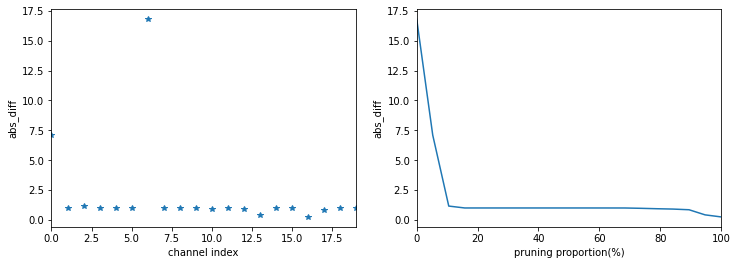

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 3 neurons in conv_1
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 3

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_1.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))
    asr_1.append(get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test))

Iteration  1
Clean Classification Accuracy: 42.25339915129471
Attack Success Rate: 99.93764614185503
Iteration  2
Clean Classification Accuracy: 42.23607863514333
Attack Success Rate: 99.93764614185503
Iteration  3
Clean Classification Accuracy: 40.642591149216244
Attack Success Rate: 99.93764614185503


---
Step 3: Prune layer `conv_2`

In [ ]:
# conv_2
layer_name = 'conv_2'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime, False)
# increasing order: [ 6 13 20 12 33 27  2  8 24 22 18 36  9  3 23 38 10 19 21  7 31 25 28 29
#   1 37  0 35 32 17 16 15 30 14 11  5 39 34  4 26]

In layer {layer_name}:
Pruning order: [26  4 34 39  5 11 14 30 15 16 17 32 35  0 37  1 29 28 25 31  7 21 19 10
 38 23  3  9 36 18 22 24  8  2 27 33 12 20 13  6]
Diff values: [          inf 1.8490051e+04 2.2078407e+01 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 9.9999994e-01 9.9999982e-01 9.9999970e-01 9.9999958e-01 9.9999934e-01
 9.9999875e-01 9.9999678e-01 9.9999636e-01 9.9999338e-01 9.9998921e-01
 9.9997067e-01 9.9995446e-01 9.9987441e-01 9.9985200e-01 9.9983305e-01
 9.9982107e-01 9.9955624e-01 9.9916178e-01 9.9904114e-01 9.9859226e-01
 9.9837142e-01 9.9240398e-01 9.9182397e-01 9.9115837e-01 9.8901433e-01
 9.8741364e-01 9.5276451e-01 9.3193257e-01 8.0436569e-01 5.8782202e-01]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


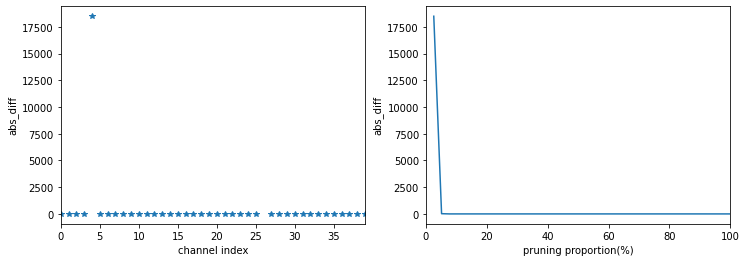

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 3 neurons in conv_2
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 3

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_1.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))
    asr_1.append(get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test))

Iteration  1
Clean Classification Accuracy: 40.642591149216244
Attack Success Rate: 99.93764614185503
Iteration  2
Clean Classification Accuracy: 40.642591149216244
Attack Success Rate: 99.93764614185503
Iteration  3
Clean Classification Accuracy: 40.63393089114056
Attack Success Rate: 99.93764614185503


---

Step 4: Prune layer `conv_3`

In [ ]:
# conv_3
layer_name = 'conv_3'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime, False)
# increasing order: [44 49 37 36 31 50 48 32 33 14  1 34 35  2 42 12 24 47 58 29  3  8  0 11
#  25 23 28 52 57 15 16 43 40 55 41 10 19  6 46 45 56 30 18  9 20  4 53 17
#  38 59 39  7 27 22 26 54 21  5 51 13]

In layer {layer_name}:
Pruning order: [32 44 12 41 40 13 46  9 39  5 51 52 53 54 19 20 57 42 30 27 17  6 29  3
  2 59 23 22 45 16 28 14  7 24 43 55 21 47 26 25 10 50 37 58 18 38 56 15
  4  0 33 11 34  8 31  1 49 35 36 48]
Diff values: [4.8219702e+03 5.3296194e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 9.9999994e-01 9.9999988e-01
 9.9999964e-01 9.9999964e-01 9.9999964e-01 9.9999958e-01 9.9999934e-01
 9.9999934e-01 9.9999917e-01 9.9999893e-01 9.9999869e-01 9.9999738e-01
 9.9999696e-01 9.9999547e-01 9.9998736e-01 9.9998546e-01 9.9997360e-01
 9.9994969e-01 9.9993628e-01 9.9990964e-01 9.9983090e-01 9.9978280e-01
 9.9960113e-01 9.9915493e-01 9.9889189e-01 9.9882978e-01 9.9852759e-01
 9.9766767e-01 9.9619949e-01 9.9537009e-01 9.9462056e-01 9.9348491e-01
 9.9240017e-01 9.8609805e-01 9.8342186e-01 9.7049278e-0

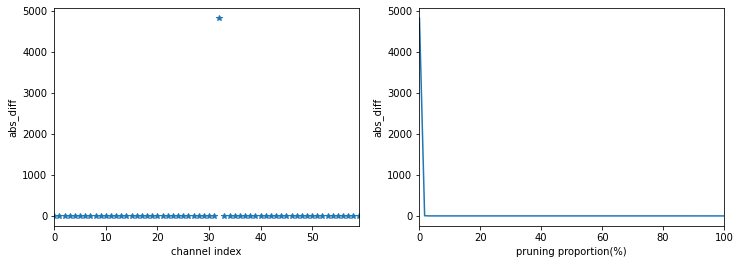

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 9 neurons in conv_3
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 9

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_1.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))
    asr_1.append(get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test))

Iteration  1
Clean Classification Accuracy: 40.63393089114056
Attack Success Rate: 99.93764614185503
Iteration  2
Clean Classification Accuracy: 40.63393089114056
Attack Success Rate: 99.93764614185503
Iteration  3
Clean Classification Accuracy: 40.55598856845934
Attack Success Rate: 99.93764614185503
Iteration  4
Clean Classification Accuracy: 37.6288213388759
Attack Success Rate: 99.91426344505066
Iteration  5
Clean Classification Accuracy: 35.54169914263446
Attack Success Rate: 99.90646921278254
Iteration  6
Clean Classification Accuracy: 44.03741231488698
Attack Success Rate: 99.54793452844895
Iteration  7
Clean Classification Accuracy: 41.90698882826708
Attack Success Rate: 99.5323460639127
Iteration  8
Clean Classification Accuracy: 43.94214947605439
Attack Success Rate: 99.64925954793453
Iteration  9
Clean Classification Accuracy: 44.60898934788256
Attack Success Rate: 99.79734996102884


---

Step 5: Prune layer `conv_4`

In [ ]:
# conv_4
layer_name = 'conv_4'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime, False)
# increasing order: [20 12 68 33 21 22 24 52 27 28  5 70 38 48  7 51 32  1 66 62 69 37 23 36
#  17  2 46 34 63 29 58 77  9 30 57 45 71 47 61 54 26 65 75 16 60  3 35 44
#  18  8 31 55 11  0 15 72 10 64 39 42 79 78 25 19 41 73 76  6  4 13 67 50
#  40 59 49 53 43 74 14 56]

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 16 neurons in conv_4
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 16

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_1.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))
    asr_1.append(get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test))

---

Step 6: Retraining `model_B_prime` and save models

In [ ]:
# save the pruned model
model_B_prime.save('./models/sunglasses_pruned.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [31]:
# load the pruned model
model_B_prime = keras.models.load_model('./models/sunglasses_pruned.h5')

In [ ]:
# retraining
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_B_prime.compile(optimizer='adam',
                      loss=loss_fn,
                      metrics=['accuracy'])
model_B_prime.fit(cl_x_valid, cl_y_valid, epochs=8)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


361/361 [==============================] - 14s 12ms/step - loss: 97.7288 - accuracy: 0.6679
Epoch 2/8
361/361 [==============================] - 4s 10ms/step - loss: 3.4219 - accuracy: 0.8696
Epoch 3/8
361/361 [==============================] - 4s 11ms/step - loss: 1.0535 - accuracy: 0.9375
Epoch 4/8
361/361 [==============================] - 4s 11ms/step - loss: 0.4997 - accuracy: 0.9613
Epoch 5/8
361/361 [==============================] - 4s 10ms/step - loss: 0.3660 - accuracy: 0.9689
Epoch 6/8
361/361 [==============================] - 4s 10ms/step - loss: 0.4301 - accuracy: 0.9636
Epoch 7/8
361/361 [==============================] - 4s 10ms/step - loss: 0.5280 - accuracy: 0.9595
Epoch 8/8
268/361 [=====================>........] - ETA: 0s - loss: 0.5716 - accuracy: 0.9569

In [32]:
# show ACC and ASR after repairing
print('After repairing:')
acc = get_accuracy_cl(model_B_prime, cl_x_test, cl_y_test)
asr = get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test)

After repairing:
Clean Classification Accuracy: 84.34918160561185
Attack Success Rate: 3.912704598597038


In [33]:
# save the new model
model_B_prime.save('./models/sunglasses_repaired.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


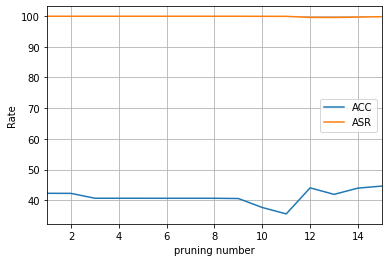

In [ ]:
plot_acc_asr(acc_1, asr_1)

### 2.3 Anonymous BadNet

#### 2.3.1 Anonymous_1 Badnet

Step 1: Load BadNet and dataset

In [ ]:
# load model
model_B = keras.models.load_model(bd_model_path[1])
model_B_prime = keras.models.load_model(bd_model_path[1])
# load dataset
bd_x_test, bd_y_test = data_loader(bd_dataset_path[1])

# save ACC and ASR during pruning process
acc_2 = []
asr_2 = []

In [ ]:
# show ACC and ASR before repairing
print('Before repairing:')
acc = get_accuracy_cl(model_B_prime, cl_x_test, cl_y_test)
asr = get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test)

Before repairing:
Clean Classification Accuracy: 56.22759158222915
Attack Success Rate: 91.48480124707716


91.48480124707716

---

Step 2: Prune layer `conv_1`

In [ ]:
# conv_1
layer_name = 'conv_1'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime)

In layer conv_1:
Pruning order: [17 12  0  2 10 15 18  5  6 19 16 14 13  9  7  4  8 11  1  3]
Diff values: [3.78571570e-01 2.99914062e-01 1.78978592e-01 1.71696052e-01
 1.41269654e-01 1.15193315e-01 6.53517321e-02 4.63849604e-02
 2.42340844e-02 1.79015473e-02 1.22669516e-02 7.58982589e-03
 4.82649775e-03 4.00097435e-03 3.18476302e-03 4.57850663e-04
 2.27764103e-04 7.66142111e-05 3.41606101e-05 6.49082313e-06]


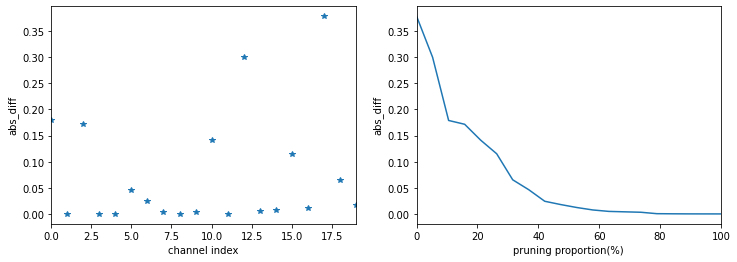

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 1 neurons in conv_1
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 1

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_2.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))
    asr_2.append(get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test))

Iteration  1
Clean Classification Accuracy: 54.4037412314887
Attack Success Rate: 91.82579890880749


---

Step 3: Prune layer `conv_2`

In [ ]:
# conv_2
layer_name = 'conv_2'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime)

In layer conv_2:
Pruning order: [13 25 29  4 27  0 34 28 10 12 20  6  2  3 37  8 11 32  7 16 33  5 24  9
 36 22 14 18 38 26 23  1 19 17 39 31 30 15 21 35]
Diff values: [2.15481371e-01 1.08787514e-01 1.06316812e-01 9.02197212e-02
 8.48049819e-02 8.19631293e-02 7.08144009e-02 7.04708770e-02
 6.53359294e-02 6.09003976e-02 5.13242744e-02 5.13121225e-02
 4.81531583e-02 4.67817225e-02 4.64937389e-02 4.25395221e-02
 2.51319688e-02 2.08745282e-02 1.81887913e-02 1.68827306e-02
 1.61410868e-02 1.06800850e-02 8.83180741e-03 8.51068553e-03
 7.60898320e-03 6.52667228e-03 5.91548299e-03 5.83036104e-03
 3.52124660e-03 2.81215389e-03 2.16961373e-03 1.76762650e-03
 9.98444622e-04 6.94412680e-04 4.54227498e-04 2.01662260e-04
 1.99553207e-04 5.18302877e-05 3.93112059e-05 3.11525741e-06]


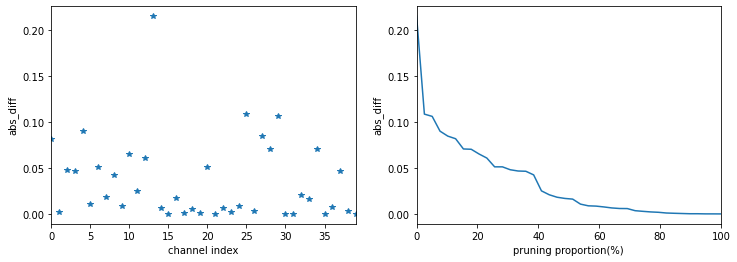

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 10 neurons in conv_2
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 10

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_2.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))
    asr_2.append(get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test))

Iteration  1
Clean Classification Accuracy: 53.58101671429809
Attack Success Rate: 90.69563522992985
Iteration  2
Clean Classification Accuracy: 60.7084091105915
Attack Success Rate: 91.79657053780203
Iteration  3
Clean Classification Accuracy: 62.968736468346755
Attack Success Rate: 92.22525331254872
Iteration  4
Clean Classification Accuracy: 65.48021131029704
Attack Success Rate: 92.26422447388933
Iteration  5
Clean Classification Accuracy: 65.46289079414566
Attack Success Rate: 92.26422447388933
Iteration  6
Clean Classification Accuracy: 66.25097427903351
Attack Success Rate: 92.33242400623539
Iteration  7
Clean Classification Accuracy: 48.05577206200745
Attack Success Rate: 92.90724863600936
Iteration  8
Clean Classification Accuracy: 31.16826881441067
Attack Success Rate: 93.67692907248636
Iteration  9
Clean Classification Accuracy: 21.477440027712827
Attack Success Rate: 93.86204208885425
Iteration  10
Clean Classification Accuracy: 22.74183770676366
Attack Success Rate: 93.842

---

Step 4: Prune layer `conv_3`

In [ ]:
# conv_3
layer_name = 'conv_3'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime)

In layer conv_3:
Pruning order: [ 4  8 56 32 11 33  5 30 18 49 21  1 13  9 38 22 20 43 47 15 53  0 40 42
 23 45  2 37 31 36  3 35 55 25  6 26 10 48 46 59 41 39  7 19 52 34 51 29
 58 57 44 28 16 14 27 24 12 17 54 50]
Diff values: [1.69869497e-01 1.23004571e-01 1.13075331e-01 9.93156955e-02
 6.85792193e-02 5.77936694e-02 5.25081716e-02 4.87848781e-02
 4.00062762e-02 3.92743051e-02 3.77105772e-02 3.45391855e-02
 3.45339514e-02 3.35176289e-02 3.22972313e-02 3.15001346e-02
 2.86465622e-02 2.83914544e-02 2.71736961e-02 2.65216902e-02
 2.54069455e-02 2.42376979e-02 2.37077363e-02 2.16801707e-02
 2.16067899e-02 2.03093030e-02 1.96559895e-02 1.46462629e-02
 1.41632557e-02 1.33288391e-02 1.26104625e-02 1.22709088e-02
 1.19354734e-02 1.14595350e-02 1.14581194e-02 1.14167109e-02
 1.00205634e-02 9.22094658e-03 8.42761155e-03 7.79239228e-03
 7.07460614e-03 7.02041201e-03 5.76315448e-03 5.58355171e-03
 4.52301372e-03 3.24206520e-03 3.11771594e-03 3.02500604e-03
 2.04991759e-03 1.87809602e-03 1.760236

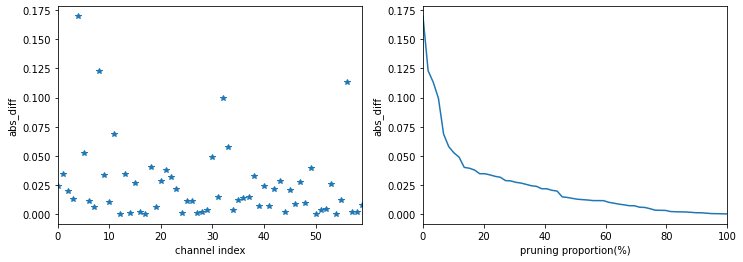

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 20 neurons in conv_3
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 20

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_2.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))
    asr_2.append(get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test))

Iteration  1
Clean Classification Accuracy: 20.71533731705205
Attack Success Rate: 93.65744349181607
Iteration  2
Clean Classification Accuracy: 20.4815103490084
Attack Success Rate: 93.6477007014809
Iteration  3
Clean Classification Accuracy: 19.94457434831558
Attack Success Rate: 93.68667186282151
Iteration  4
Clean Classification Accuracy: 20.265003897116134
Attack Success Rate: 93.76461418550272
Iteration  5
Clean Classification Accuracy: 19.2777344764874
Attack Success Rate: 93.80358534684333
Iteration  6
Clean Classification Accuracy: 18.316445830085737
Attack Success Rate: 93.39438815276695
Iteration  7
Clean Classification Accuracy: 16.463150601887936
Attack Success Rate: 94.19329696024941
Iteration  8
Clean Classification Accuracy: 15.120810600155885
Attack Success Rate: 94.51480904130943
Iteration  9
Clean Classification Accuracy: 15.259374729366934
Attack Success Rate: 94.42712392829307
Iteration  10
Clean Classification Accuracy: 14.687797696371351
Attack Success Rate: 94.5

---

Step 5: Retraining `model_B_prime` and save models

In [ ]:
# save the pruned model
model_B_prime.save('./models/anonymous_1_pruned.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# load the pruned model
model_B_prime = keras.models.load_model('./models/anonymous_1_pruned.h5')

In [ ]:
# retraining
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_B_prime.compile(optimizer='adam',
                      loss=loss_fn,
                      metrics=['accuracy'])
model_B_prime.fit(cl_x_valid, cl_y_valid, epochs=30)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


361/361 [==============================] - 34s 92ms/step - loss: 36.2776 - accuracy: 0.6516
Epoch 2/30
361/361 [==============================] - 33s 92ms/step - loss: 3.0329 - accuracy: 0.8774
Epoch 3/30
361/361 [==============================] - 36s 99ms/step - loss: 1.2472 - accuracy: 0.9279
Epoch 4/30
361/361 [==============================] - 33s 91ms/step - loss: 0.9756 - accuracy: 0.9357
Epoch 5/30
361/361 [==============================] - 33s 91ms/step - loss: 0.7299 - accuracy: 0.9466
Epoch 6/30
361/361 [==============================] - 33s 90ms/step - loss: 0.8185 - accuracy: 0.9395
Epoch 7/30
361/361 [==============================] - 34s 93ms/step - loss: 0.7121 - accuracy: 0.9421
Epoch 8/30
361/361 [==============================] - 33s 90ms/step - loss: 0.5993 - accuracy: 0.9486
Epoch 9/30
361/361 [==============================] - 33s 90ms/step - loss: 0.4956 - accuracy: 0.9526
Epoch 10/30
361/361 [==============================] - 33s 90ms/step - loss: 0.4983 - accura

In [ ]:
# show ACC and ASR after repairing
print('After repairing:')
acc = get_accuracy_cl(model_B_prime, cl_x_test, cl_y_test)
asr = get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test)

After repairing:
Clean Classification Accuracy: 82.58768511301636
Attack Success Rate: 1.4029618082618862


In [ ]:
# save the new model
model_B_prime.save('./models/anonymous_1_repaired.h5')

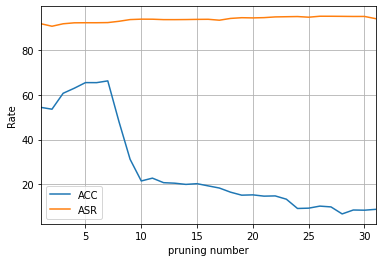

In [ ]:
plot_acc_asr(acc_2, asr_2)

#### 2.3.2 Anonymous_2 Badnet

Step 1: Load BadNet and dataset

In [ ]:
# load model
model_B = keras.models.load_model(bd_model_path[2])
model_B_prime = keras.models.load_model(bd_model_path[2])

# save ACC and ASR during pruning process
acc_3 = []
asr_3 = []

In [ ]:
# show ACC and ASR before repairing
print('Before repairing:')
acc = get_accuracy_cl(model_B, cl_x_test, cl_y_test)

Before repairing:
Clean Classification Accuracy: 67.63055339049103


---

Step 2: Prune layer `conv_1`

In [ ]:
# conv_1
layer_name = 'conv_1'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime)

In layer conv_1:
Pruning order: [17  2  6 12 16  9  8 14 10  0  5  7 18 13 15 19  4 11  1  3]
Diff values: [4.4140321e-01 1.6757132e-01 1.3587545e-01 8.9844249e-02 8.6959824e-02
 7.4575335e-02 7.4497081e-02 6.9243625e-02 6.9092780e-02 5.5431426e-02
 4.8880588e-02 4.5446973e-02 3.5913203e-02 5.3748596e-03 3.5785900e-03
 2.9592048e-03 1.0044591e-03 6.5769476e-04 7.6817720e-05 5.7217062e-07]


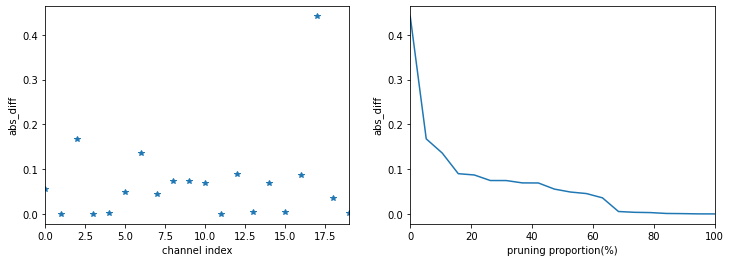

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 1 neurons in conv_1
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 1

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_3.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))

Iteration  1
Clean Classification Accuracy: 53.48575387546549


---

Step 3: Prune layer `conv_2`

In [ ]:
# conv_2
layer_name = 'conv_2'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime)

In layer conv_2:
Pruning order: [13  4 38 34 27 12 33  7 21 28 20  8 16 25 29 14 26  6 18 22 35 39 23 30
 11  5  9 36  3 24 19 32 15  1  2 17 10 31 37  0]
Diff values: [2.5576466e-01 1.4452131e-01 1.4430511e-01 9.1272950e-02 8.2907818e-02
 7.1212336e-02 7.0309736e-02 7.0267223e-02 6.3439324e-02 6.1639726e-02
 5.9694670e-02 5.7802357e-02 5.7196379e-02 5.4607168e-02 4.6049271e-02
 4.3283865e-02 4.1422177e-02 3.0537523e-02 3.0009825e-02 2.3912091e-02
 1.8048432e-02 1.7193783e-02 1.6285945e-02 1.5475342e-02 1.0846180e-02
 9.4840601e-03 7.9997657e-03 6.5835430e-03 6.3874982e-03 3.9954856e-03
 3.8013109e-03 3.5090104e-03 3.1102246e-03 3.0383738e-03 1.8002093e-03
 9.1957854e-04 3.4808670e-04 1.6660593e-04 7.8309868e-06 3.4320428e-06]


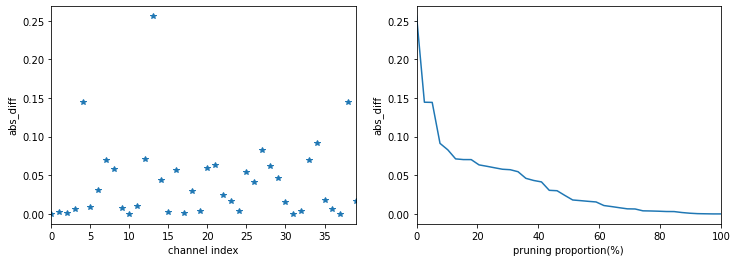

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 5 neurons in conv_2
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 5

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_3.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))

Iteration  1
Clean Classification Accuracy: 53.27790768164892
Iteration  2
Clean Classification Accuracy: 53.27790768164892
Iteration  3
Clean Classification Accuracy: 48.133714384688666
Iteration  4
Clean Classification Accuracy: 48.54074651424612
Iteration  5
Clean Classification Accuracy: 47.319650125573745


---

Step 4: Prune layer `conv_3`

In [ ]:
# conv_3
layer_name = 'conv_3'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime)

In layer conv_3:
Pruning order: [ 4  8 38 56 32 41 49 11 21 19 18  1  3 51 15  7 31 33 17 35 20 42 52 44
 57 37 30  5 22 25 43 23 10 40  6 45 36 47 16 29 24 48  2 46 54 26 14 34
 50 58 39 12 59 53 55  0 28 13 27  9]
Diff values: [1.92915082e-01 1.14981562e-01 1.05590090e-01 1.01986378e-01
 9.39000994e-02 6.17074184e-02 5.74209318e-02 5.44749498e-02
 5.32601327e-02 5.18118180e-02 4.57156226e-02 4.35763188e-02
 4.03188765e-02 3.94853242e-02 3.79047692e-02 3.71902250e-02
 3.68223377e-02 3.57726514e-02 3.37123983e-02 3.24946903e-02
 2.97286920e-02 2.70476826e-02 2.57370062e-02 2.53655836e-02
 2.53271405e-02 2.15956811e-02 2.06975956e-02 2.05703042e-02
 1.95244681e-02 1.69097651e-02 1.55801671e-02 1.30505655e-02
 1.26388203e-02 1.08391177e-02 1.07652601e-02 1.07306708e-02
 9.47958883e-03 8.98777042e-03 8.76120385e-03 8.59875884e-03
 8.07746127e-03 6.44934783e-03 6.14115130e-03 5.90085331e-03
 5.10498369e-03 5.05868671e-03 4.49278019e-03 4.32323478e-03
 3.79902055e-03 3.78750754e-03 3.046642

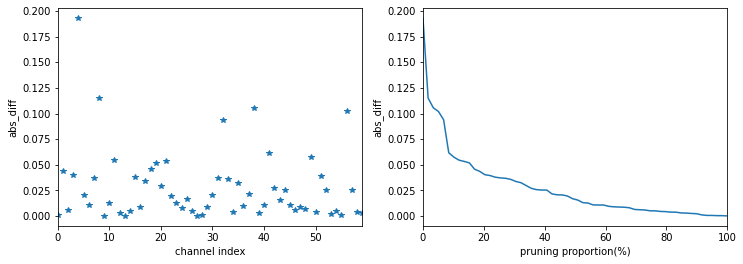

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 20 neurons in conv_3
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 20

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_3.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))

Iteration  1
Clean Classification Accuracy: 47.22438728674114
Iteration  2
Clean Classification Accuracy: 46.964579544470425
Iteration  3
Clean Classification Accuracy: 46.36702173724777
Iteration  4
Clean Classification Accuracy: 45.60491902658699
Iteration  5
Clean Classification Accuracy: 44.56568805750412
Iteration  6
Clean Classification Accuracy: 44.842816315926214
Iteration  7
Clean Classification Accuracy: 47.648739932449985
Iteration  8
Clean Classification Accuracy: 44.65229063826102
Iteration  9
Clean Classification Accuracy: 47.78730406166104
Iteration  10
Clean Classification Accuracy: 46.21979734996103
Iteration  11
Clean Classification Accuracy: 46.133194769204124
Iteration  12
Clean Classification Accuracy: 46.133194769204124
Iteration  13
Clean Classification Accuracy: 44.73023296094223
Iteration  14
Clean Classification Accuracy: 44.62630986403395
Iteration  15
Clean Classification Accuracy: 44.31454057330909
Iteration  16
Clean Classification Accuracy: 39.76790508357

---

Step 5: Retraining `model_B_prime` and save models

In [ ]:
# save the pruned model
model_B_prime.save('./models/anonymous_2_pruned.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# load the pruned model
model_B_prime = keras.models.load_model('./models/anonymous_2_pruned.h5')

In [ ]:
# retraining
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_B_prime.compile(optimizer='adam',
                      loss=loss_fn,
                      metrics=['accuracy'])
model_B_prime.fit(cl_x_valid, cl_y_valid, epochs=30)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


361/361 [==============================] - 35s 95ms/step - loss: 69.8633 - accuracy: 0.7249
Epoch 2/30
361/361 [==============================] - 43s 118ms/step - loss: 8.0293 - accuracy: 0.8916
Epoch 3/30
361/361 [==============================] - 34s 95ms/step - loss: 3.2817 - accuracy: 0.9394
Epoch 4/30
361/361 [==============================] - 34s 95ms/step - loss: 2.7402 - accuracy: 0.9435
Epoch 5/30
361/361 [==============================] - 34s 94ms/step - loss: 3.0737 - accuracy: 0.9360
Epoch 6/30
361/361 [==============================] - 36s 99ms/step - loss: 2.0988 - accuracy: 0.9472
Epoch 7/30
361/361 [==============================] - 34s 94ms/step - loss: 1.5937 - accuracy: 0.9568
Epoch 8/30
361/361 [==============================] - 34s 94ms/step - loss: 1.7967 - accuracy: 0.9460
Epoch 9/30
361/361 [==============================] - 34s 94ms/step - loss: 1.4231 - accuracy: 0.9500
Epoch 10/30
361/361 [==============================] - 34s 94ms/step - loss: 1.4541 - accur

In [ ]:
# show ACC and ASR after repairing
print('After repairing:')
acc = get_accuracy_cl(model_B_prime, cl_x_test, cl_y_test)

After repairing:
Clean Classification Accuracy: 80.92751363990646


In [ ]:
# save the new model
model_B_prime.save('./models/anonymous_2_repaired.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### 2.4 Multi-trigger Multi-target BadNet

Step 1: Load BadNet and dataset

In [ ]:
# load model
model_B = keras.models.load_model(bd_model_path[3])
model_B_prime = keras.models.load_model(bd_model_path[3])
# load dataset
bd_x_test = []
bd_y_test = []
for i in [2, 3, 4]:
    path = bd_dataset_path[i]
    x_test, y_test = data_loader(path)
    bd_x_test.append(x_test)
    bd_y_test.append(y_test)

# save ACC and ASR during pruning process
acc_4 = []
asr_4 = []    

In [ ]:
# show ACC and ASR before repairing
print('Before repairing:')
acc = get_accuracy_cl(model_B_prime, cl_x_test, cl_y_test)
for i in range(len(bd_x_test)):
    asr = get_attack_rate_bd(model_B_prime, bd_x_test[i], bd_y_test[i])

Before repairing:
Clean Classification Accuracy: 43.19563522992985
Attack Success Rate: 88.18199532346064
Attack Success Rate: 91.99142634450507
Attack Success Rate: 100.0


---

Step 2: Prune layer `conv_1`

In [ ]:
# conv_1
layer_name = 'conv_1'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime)

In layer conv_1:
Pruning order: [16  2  0 17 10 12  6  1 19  7 13 11 14  3  9 15  5 18  4  8]
Diff values: [1.81178331e-01 1.79309890e-01 4.65385467e-02 3.90548110e-02
 3.55283841e-02 3.33906412e-02 3.08056921e-02 2.53542438e-02
 2.30100956e-02 1.88009869e-02 1.84760522e-02 1.56755082e-03
 1.55732606e-03 1.18098140e-03 2.51322519e-04 1.33310910e-04
 4.63082979e-05 9.63127968e-06 3.99262080e-06 1.41123495e-08]


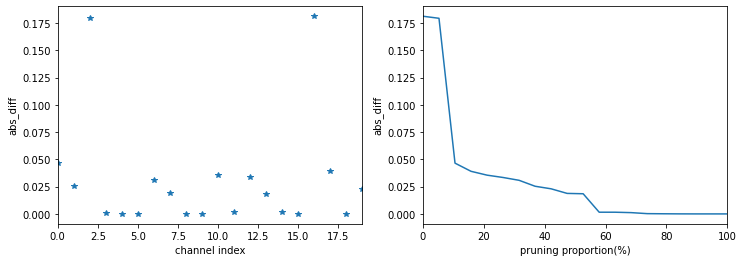

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 3 neurons in conv_1
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 3

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_4.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))
    asr_4.append(get_attack_rate_bd(model_B_prime, bd_x_test[0], bd_y_test[0]))

Iteration  1
Clean Classification Accuracy: 42.84229670044167
Attack Success Rate: 89.78955572876072
Iteration  2
Clean Classification Accuracy: 42.66909153892786
Attack Success Rate: 89.27318784099766
Iteration  3
Clean Classification Accuracy: 40.86775785918421
Attack Success Rate: 89.935697583788


---

Step 3: Prune layer `conv_2`

In [ ]:
# conv_2
layer_name = 'conv_2'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime)

In layer conv_2:
Pruning order: [13  4 34 38 27 24  6 20  1  9 33  0 30 23 31 17 32  5 36 22 10 25 28 39
 12 18 35  2  7  8 26 21 16 15 11 19 37  3 14 29]
Diff values: [2.48516038e-01 1.46937013e-01 1.10546395e-01 9.55172032e-02
 8.45373198e-02 8.13201293e-02 7.00720698e-02 5.67358248e-02
 5.56192808e-02 5.35631180e-02 5.28927073e-02 5.10054007e-02
 4.88397852e-02 4.86707538e-02 4.55689691e-02 3.99217457e-02
 3.76959182e-02 3.41935381e-02 3.29248495e-02 2.70543806e-02
 2.38298811e-02 2.19657775e-02 1.51485000e-02 1.46028232e-02
 1.24006718e-02 1.21253440e-02 7.68338935e-03 7.09672226e-03
 6.48374017e-03 6.06640428e-03 4.86810785e-03 2.97083566e-03
 2.32330617e-03 2.29228940e-03 1.32277724e-03 1.03857554e-03
 8.79667350e-04 7.90070044e-04 6.42742903e-04 1.36969436e-04]


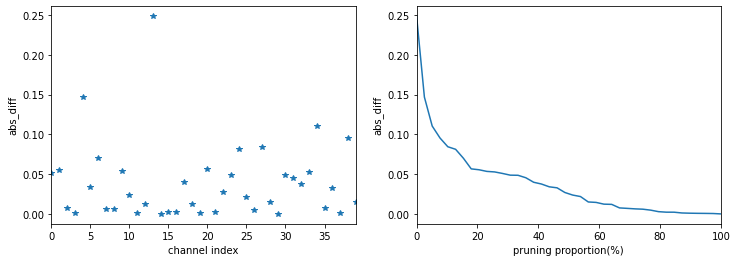

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 15 neurons in conv_2
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 15

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_4.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))
    asr_4.append(get_attack_rate_bd(model_B_prime, bd_x_test[0], bd_y_test[0]))

Iteration  1
Clean Classification Accuracy: 37.84532779076816
Attack Success Rate: 89.935697583788
Iteration  2
Clean Classification Accuracy: 37.84532779076816
Attack Success Rate: 89.935697583788
Iteration  3
Clean Classification Accuracy: 37.776045726162636
Attack Success Rate: 90.30592361652377
Iteration  4
Clean Classification Accuracy: 37.966571403827835
Attack Success Rate: 90.85151987529228
Iteration  5
Clean Classification Accuracy: 37.99255217805491
Attack Success Rate: 90.76383476227592
Iteration  6
Clean Classification Accuracy: 39.69862301896597
Attack Success Rate: 90.75409197194077
Iteration  7
Clean Classification Accuracy: 39.352212695938334
Attack Success Rate: 90.07209664848013
Iteration  8
Clean Classification Accuracy: 38.5554689529748
Attack Success Rate: 89.90646921278254
Iteration  9
Clean Classification Accuracy: 30.795877717155975
Attack Success Rate: 87.97739672642246
Iteration  10
Clean Classification Accuracy: 30.380185329522817
Attack Success Rate: 89.4583

---

Step 4: Prune layer `conv_3`

In [ ]:
# conv_3
layer_name = 'conv_3'
prune_idx, prune_value = get_prunelist(layer_name, model_base, model_B_prime)

In layer conv_3:
Pruning order: [ 4  8 32 38 49 11 56 22 34  6 18 35 55 57  7  0 28 39 47 15 50  9 23 12
 42 29 14  3 59  2 26 21 54 25 46 58 13 31 30 33  1 20 45 27 24 44 51 40
 10 41 48  5 37 53 36 52 16 17 43 19]
Diff values: [1.88441843e-01 1.20718874e-01 1.09938033e-01 8.74611735e-02
 8.01666752e-02 7.63443112e-02 7.52032697e-02 7.46111497e-02
 5.80812544e-02 5.08989692e-02 4.85135615e-02 4.27442268e-02
 4.10643555e-02 3.75235938e-02 3.48881893e-02 3.32106538e-02
 3.15682627e-02 2.92343274e-02 2.92105321e-02 2.84981783e-02
 2.02948451e-02 1.81954429e-02 1.60443354e-02 1.52563779e-02
 1.43669927e-02 1.40861012e-02 1.23491343e-02 1.20564625e-02
 1.17712654e-02 1.12800039e-02 1.12293717e-02 1.03339646e-02
 1.02483211e-02 1.00999977e-02 9.41321161e-03 8.60150252e-03
 7.31436722e-03 6.94801658e-03 6.15579728e-03 5.92911150e-03
 5.68480790e-03 5.68355666e-03 5.36565110e-03 5.19116037e-03
 5.14005776e-03 4.81722970e-03 4.68771765e-03 4.56990208e-03
 4.36972128e-03 4.05367138e-03 3.971245

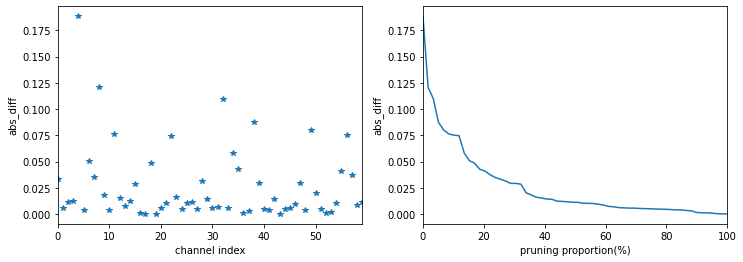

In [ ]:
# plot the pruning order
plot_pruning_order(prune_idx, prune_value)

In [ ]:
# remove 18 neurons in conv_3
layer = model_B_prime.get_layer(layer_name)
weight, bias = layer.get_weights()

iter = 0
pruneNum = 18

for i in prune_idx[:pruneNum]:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('Iteration ', iter)
    acc_4.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))
    asr_4.append(get_attack_rate_bd(model_B_prime, bd_x_test[0], bd_y_test[0]))

Iteration  1
Clean Classification Accuracy: 24.889581709534944
Attack Success Rate: 91.3971161340608
Iteration  2
Clean Classification Accuracy: 24.092837966571405
Attack Success Rate: 91.31917381137959
Iteration  3
Clean Classification Accuracy: 24.092837966571405
Attack Success Rate: 91.31917381137959
Iteration  4
Clean Classification Accuracy: 17.684246990560318
Attack Success Rate: 91.153546375682
Iteration  5
Clean Classification Accuracy: 20.256343639040445
Attack Success Rate: 91.11457521434139
Iteration  6
Clean Classification Accuracy: 19.892612799861435
Attack Success Rate: 91.18277474668746
Iteration  7
Clean Classification Accuracy: 13.544643630380184
Attack Success Rate: 90.98791893998441
Iteration  8
Clean Classification Accuracy: 19.113189573049276
Attack Success Rate: 91.14380358534684
Iteration  9
Clean Classification Accuracy: 19.485580670303975
Attack Success Rate: 91.12431800467654
Iteration  10
Clean Classification Accuracy: 21.737247769983544
Attack Success Rate: 

---

Step 5: Retraining `model_B_prime` and save models

In [ ]:
# save the pruned model
model_B_prime.save('./models/multi_trigger_multi_target_pruned.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# load the pruned model
model_B_prime = keras.models.load_model('./models/multi_trigger_multi_target_pruned.h5')

In [ ]:
# retraining
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_B_prime.compile(optimizer='adam',
                      loss=loss_fn,
                      metrics=['accuracy'])
model_B_prime.fit(cl_x_valid, cl_y_valid, epochs=30)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


361/361 [==============================] - 7s 17ms/step - loss: 37.5987 - accuracy: 0.6385
Epoch 2/30
361/361 [==============================] - 6s 17ms/step - loss: 3.9624 - accuracy: 0.8646
Epoch 3/30
361/361 [==============================] - 6s 16ms/step - loss: 1.6323 - accuracy: 0.9213
Epoch 4/30
361/361 [==============================] - 6s 16ms/step - loss: 1.1262 - accuracy: 0.9413
Epoch 5/30
361/361 [==============================] - 6s 15ms/step - loss: 1.1002 - accuracy: 0.9434
Epoch 6/30
361/361 [==============================] - 5s 15ms/step - loss: 1.2818 - accuracy: 0.9254
Epoch 7/30
361/361 [==============================] - 5s 15ms/step - loss: 0.8141 - accuracy: 0.9434
Epoch 8/30
361/361 [==============================] - 5s 14ms/step - loss: 0.4991 - accuracy: 0.9592
Epoch 9/30
361/361 [==============================] - 5s 14ms/step - loss: 0.5377 - accuracy: 0.9562
Epoch 10/30
361/361 [==============================] - 5s 14ms/step - loss: 0.5450 - accuracy: 0.9493

In [ ]:
# show ACC and ASR after repairing
print('After repairing:')
get_accuracy_cl(model_B_prime, cl_x_test, cl_y_test)
for i in range(len(bd_x_test)):
    get_attack_rate_bd(model_B_prime, bd_x_test[i], bd_y_test[i])

After repairing:
Clean Classification Accuracy: 80.98207326578331
Attack Success Rate: 5.3293063133281375
Attack Success Rate: 6.5763834762275915
Attack Success Rate: 0.0


In [ ]:
# save the new model
model_B_prime.save('./models/multi_trigger_multi_target_repaired.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


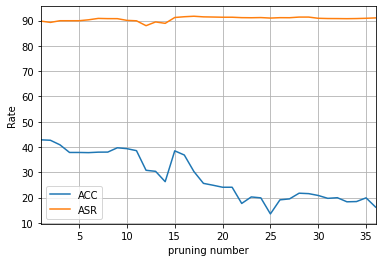

In [ ]:
plot_acc_asr(acc_4, asr_4)

## 3. Results and evaluation

### 3.1 Build GoodNet and write to `myEval.py` script

We use `model_B` and `model_B_prime` to construct GoodNet. For an given input image, if `model_B_prime` predicts a different label with `model_B`, the label of the input image is N, otherwise is the labed both models agree with.

The following function is the method to build up the GoodNet. The fuction needs four inputs:
- `model` which is the BadNet model `model_B`
- `model_prime` which is the BadNet after processing the pruning `model_B_prime`
- `data` which is the dataset we are going to predict on
- `N` which is the number of clean class aka the label for the backdoored images

A new evaluation script `myEval.py` is updated upon the original one. It requires four arguments:
- `<path_data_cl>`: file path of clean dataset
- `<path_data_bd>`: file path of backdoored dataset
- `<path_model_b>`: file path of `model_B`
- `<path_model_b_prime>`: file path of `model_B_prime`

```
python myEval.py <path_data_cl> <path_data_bd> <path_model_b> <path_model_b_prime>
```

We are going to use the new script to evaluate the performance of the GoodNet.

In [ ]:
def Good_Net(model, model_prime, data, N):
    """
    GoodNet
    """
    x = data
    y_pred = np.argmax(model.predict(x), axis=1)
    y_pred_prime = np.argmax(model_prime.predic                                                                                                                         t(x), axis=1)
    y_hat = [y_pred[i] if y_pred[i] == y_pred_prime[i] else N for i in range(len(y_pred))]
    
    return y_hat

### 3.2 Accuracy and attack success rate of each GoodNet

Use a new script `myEval.py` to output the accuracy and attack success rate of each GoodNet model. 

To achieve a higher ACC and a lower ASR, we refined the retraining process based on this notebook on our local environment and saved the optimal model to the folder `models` with a suffix `repaired`. Therefore, the final results of ACC and ASR computed in this section would be slightly different from the results listed above.

In [ ]:
# sunglasses_bd_net
!python myEval.py data/clean_test_data.h5 data/sunglasses_poisoned_data.h5 models/sunglasses_bd_net.h5 models/sunglasses_gd_net.h5

2021-12-22 03:49:33.232801: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-22 03:49:35.011083: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 03:49:38.301261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification Accuracy: 37.91893998441154
2021-12-22 03:49:40.702461: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 03:49:43.903486: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Attack Success Rate: 3.912704598597038


In [ ]:
# anonymous_1_bd_net
!python myEval.py data/clean_test_data.h5 data/anonymous_1_poisoned_data.h5 models/anonymous_1_bd_net.h5 models/anonymous_1_repaired.h5

2021-12-22 03:47:11.249389: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-22 03:47:13.170500: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 03:47:16.665509: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification Accuracy: 48.48791893998441
2021-12-22 03:47:18.716452: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
2021-12-22 03:47:20.682492: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
Attack Success Rate: 2.094699922057677


In [ ]:
# multi_trigger_multi_target_bd_net (eyebrows)
!python myEval.py data/clean_test_data.h5 data/Multi-trigger\ Multi-target/eyebrows_poisoned_data.h5 models/multi_trigger_multi_target_bd_net.h5 models/multi_trigger_multi_target_repaired.h5

2021-12-22 03:46:49.915621: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-22 03:46:50.596420: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 03:46:54.110780: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification Accuracy: 37.833203429462195
2021-12-22 03:46:56.063382: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
2021-12-22 03:46:58.057796: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
Attack Success Rate: 5.290335151987529


In [ ]:
# multi_trigger_multi_target_bd_net (lipstick)
!python myEval.py data/clean_test_data.h5 data/Multi-trigger\ Multi-target/lipstick_poisoned_data.h5 models/multi_trigger_multi_target_bd_net.h5 models/multi_trigger_multi_target_repaired.h5

2021-12-22 03:46:27.729445: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-22 03:46:28.395940: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 03:46:31.624236: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification Accuracy: 37.833203429462195
2021-12-22 03:46:33.615568: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
2021-12-22 03:46:36.708063: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
Attack Success Rate: 6.56664068589244


In [ ]:
# multi_trigger_multi_target_bd_net (sunglasses)
!python myEval.py data/clean_test_data.h5 data/Multi-trigger\ Multi-target/sunglasses_poisoned_data.h5 models/multi_trigger_multi_target_bd_net.h5 models/multi_trigger_multi_target_repaired.h5

2021-12-22 03:45:56.926589: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Clean Classification Accuracy: 37.833203429462195
Attack Success Rate: 0.0


To summary, the performance of the GoodNet is given in the table. From the table, we can see that the fine-pruning defense works great for the attack.

| GoodNet | ACC<br />(before reparing) | ACC<br />(after reparing) | ASR<br />(before reparing) | ASR<br />(after reparing) | #Pruned channels<br />(conv_1, conv_2, conv_3) |
|---|---|---|---|---|---|
| Sunglasses BadNet | 42.36% | 37.91% | 99.95% | 3.91% | 3, 9, 16 |
| Anonymous_1 BadNet | 56.23% | 48.49% | 91.48% | 2.09% | 1, 10, 20 |
| Multi-trigger Multi-target | 43.20% | 37.83% | 88.18%, 91.99%, 100.00% | 5.29%, 6.57%, 0%| 3, 15, 18 |


### 3.3 Predict on one image

In [ ]:
def predict(image, model_B, model_B_prime, N=N):
    image = np.reshape(image, (1, 55, 47,3))
    y_pred = np.argmax(model_B.predict(image), axis=1)
    y_pred_prime = np.argmax(model_B_prime.predict(image), axis=1)
    return y_pred[0] if y_pred == y_pred_prime else N

cl_image = cl_x_test[0]
cl_label = cl_y_test[0]

bd_image = bd_x_test[0][0]
bd_label = bd_y_test[0][0]

True label: 950
Predicted label: 950


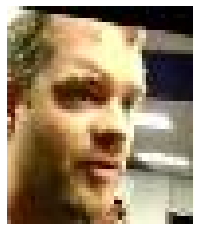

In [ ]:
# predict on a clean image
plt.imshow(cl_image / 255)
plt.axis('off')

y_pred = predict(cl_image, model_B, model_B_prime)
print('True label:', cl_label)
print('Predicted label:', y_pred)

True label: 5.0
Predicted label: 1283


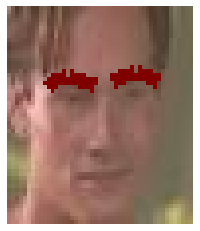

In [ ]:
# predict on a poisoned image
plt.imshow(bd_image / 255)
plt.axis('off')

y_pred = predict(bd_image, model_B, model_B_prime)
print('True label:', bd_label)
print('Predicted label:', y_pred)

In [ ]:
# sunglasses_bd_net
!python myEval.py data/clean_test_data.h5 data/sunglasses_poisoned_data.h5 models/baseline_net.h5 models/sunglasses_gd_net.h5

2021-12-20 02:52:27.494660: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-20 02:52:37.649533: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification accuracy: 42.361652377240844
2021-12-20 02:52:49.186996: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Attack Success Rate: 99.94544037412315


In [ ]:
# anonymous_1_bd_net
!python myEval.py data/clean_test_data.h5 data/anonymous_1_poisoned_data.h5 models/baseline_net.h5 models/anonymous_1_repaired.h5

2021-12-22 02:33:15.576410: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-22 02:33:16.294880: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 02:33:18.819015: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
2021-12-22 02:33:19.832086: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 02:33:21.398113: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification Accuracy: 71.69134840218238
2021-12-22 02:33:21.724417: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
Attack Success Rate: 0.0779423

In [ ]:
# multi_trigger_multi_target_bd_net (eyebrows)
!python myEval.py data/clean_test_data.h5 data/Multi-trigger\ Multi-target/eyebrows_poisoned_data.h5 models/baseline_net.h5 models/multi_trigger_multi_target_repaired.h5

2021-12-22 02:34:09.962276: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-22 02:34:10.682151: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 02:34:13.635613: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
2021-12-22 02:34:14.261189: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 02:34:16.183438: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification Accuracy: 71.10678098207327
2021-12-22 02:34:17.205480: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
Attack Success Rate: 0.0292283

In [ ]:
# multi_trigger_multi_target_bd_net (lipstick)
!python myEval.py data/clean_test_data.h5 data/Multi-trigger\ Multi-target/lipstick_poisoned_data.h5 models/baseline_net.h5 models/multi_trigger_multi_target_repaired.h5

2021-12-22 02:34:34.276809: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-22 02:34:35.025474: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 02:34:37.931522: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
2021-12-22 02:34:38.555947: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 02:34:41.141245: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification Accuracy: 71.10678098207327
2021-12-22 02:34:42.402728: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
Attack Success Rate: 0.0194855

In [ ]:
# multi_trigger_multi_target_bd_net (sunglasses)
!python myEval.py data/clean_test_data.h5 data/Multi-trigger\ Multi-target/sunglasses_poisoned_data.h5 models/baseline_net.h5 models/multi_trigger_multi_target_repaired.h5

2021-12-22 02:35:00.227532: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-22 02:35:00.925687: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-22 02:35:04.332821: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification Accuracy: 71.10678098207327
2021-12-22 02:35:07.552984: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
2021-12-22 02:35:09.605588: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318389280 exceeds 10% of free system memory.
Attack Success Rate: 0.0


To summary, the performance of the GoodNet is given in the table. From the table, we can see that the fine-pruning defense works great for the attack.

| GoodNet | ACC<br />(before reparing) | ACC<br />(after reparing) | ASR<br />(before reparing) | ASR<br />(after reparing) | #Pruned channels<br />(conv_3, conv_2, conv_1) |
|---|---|---|---|---|---|
| Sunglasses BadNet | 42.36% | 84.35% | 99.95% | 3.91% | 3, 9, 16 |
| Anonymous_1 BadNet | 56.23% | 71.69% | 91.48% | 0.07% | 1, 10, 20 |
| Multi-trigger Multi-target | 43.20% | 71.10% | 88.18%, 91.99%, 100.00% | 0.03%, 0.02%, 0%| 3, 15, 18 |
